# Assignment Two:  Sentiment Classification

For this exercise you will be using the "SemEval 2017 task 4" corpus provided on the module website, available through the following link: https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs918/semeval-tweets.tar.bz2 You will focus particularly on Subtask A, i.e. classifying the overall sentiment of a tweet as positive, negative or neutral.

You are requested to produce a Jupyter notebook for the coursework submission. The input to your program is the SemEval data downloaded. Note that TAs need to run your program on their own machine by using the original SemEval data. As such, don’t submit a Python program that takes as input some preprocessed files.

#### Import necessary packages
You may import more packages here.

In [35]:
# Import necessary packages
import re
from os.path import join
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.metrics import  classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import MultinomialNB
from torch.nn import functional as F
import gc
import matplotlib.pyplot as plt
!pip3 install contractions
import contractions
!pip3 install emoji
import emoji
import pickle
nltk.download('wordnet')
nltk.download('stopwords')

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(42)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/haritharash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haritharash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

In [37]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)
    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)
    


## Text Preprocessing

In [38]:
emoticons = {
    ':)': ' smiling face ',
    ':(': ' sad face ',
    ':D': ' grinning face ',
    ':P': ' sticking out tongue face ',
    ';)': ' winking face ',
    ':O' :' surprised face ',
    ':|' : ' neutral face ',
    ':/': ' skeptical face ',
    ':-)': ' smiling face ',
    ':-(' : ' sad face '
    }

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    
    #demojize
    text = emoji.demojize(text, language='en')
    
    text = re.sub(r"((https?|ftp)://)?[a-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]+\.[a-z]{2,}[a-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]*","",text)

    #remove all whtespace characters 
    text = re.sub(r"\s"," ",text)
    
    # Use the contractions library to expand the contraction
    text = contractions.fix(text)
    
    text = re.sub(r"(\.|!|\?) ",' ',text)
    
    #remove username
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    
    #remove hashtags
    text = re.sub(r'#([^\s]+)', '', text)
    
    for emoticon, description in emoticons.items():
        text = re.sub(re.escape(emoticon),description,text)

    # # #remove non-alphanumeric characters except spaces
    text = re.sub(r'[^\w\s]', '', text)

    #remove fully digit
    text = re.sub(r"\b[0-9]+\b","",text)

    #remove single-character words
    text = re.sub(r"\b[a-z0-9]\b","",text)
    
    # Remove the stopwords
    filtered_words = [word for word in word_tokenize(text) if word.casefold() not in stop_words]

    text = ' '.join(filtered_words)
    
    return text;

#### Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

In [39]:
import csv
import re 
# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

for dataset in ['twitter-training-data.txt','twitter-dev-data.txt'] + testsets:
    # write code to read in the datasets here
    tweet_id_per_file = []
    tweet_gts__per_file = []
    tweets_per_file = []
    data_per_file = []
    dataset_path = join('semeval-tweets', dataset)
    with open(dataset_path) as f:
        for line in csv.reader(f, delimiter="\t"):
            tweet_id = line[0]
            sentiment = line[1]
            tweet_text = line[2]
            tweets_per_file.append(preprocess(tweet_text))
            tweet_id_per_file.append(tweet_id)
            tweet_gts__per_file.append(sentiment)
            data_per_file.append(line)
            
        data[dataset] = data_per_file
        tweets[dataset] = tweets_per_file
        tweetids[dataset] = tweet_id_per_file
        tweetgts[dataset] = tweet_gts__per_file

In [40]:

def train_svm():
    tfidf = TfidfVectorizer(max_features=5000)
    X_train = tfidf.fit_transform(tweets['twitter-training-data.txt'])
    X_test = tfidf.transform(tweets['twitter-dev-data.txt'])

    clf =  LinearSVC()# SVC(kernel='rbf') #
    clf.fit(X_train, tweetgts['twitter-training-data.txt'])
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(tweetgts['twitter-dev-data.txt'], y_pred)
    precision = precision_score(tweetgts['twitter-dev-data.txt'], y_pred,average='macro')
    recall = recall_score(tweetgts['twitter-dev-data.txt'], y_pred,average='macro')
    f1 = f1_score(tweetgts['twitter-dev-data.txt'], y_pred,average='macro')

    print("Validation Linear SVM : Accuracy ",accuracy)
    print("Validation Linear SVM : Precision ",precision)
    print("Validation Linear SVM : Recall ",recall)
    print("Validation Linear SVM : F1 score ",f1)

    # print(classification_report(tweetgts['twitter-dev-data.txt'], y_pred))
    return clf

In [41]:
def train_multinomialNB():
    vectorizer = CountVectorizer(max_features=5000)
    x_train = vectorizer.fit_transform(tweets['twitter-training-data.txt'])
    x_test = vectorizer.transform(tweets['twitter-dev-data.txt'])

    # Train the Naive Bayes model
    nb = MultinomialNB()
    nb.fit(x_train, tweetgts['twitter-training-data.txt'])
    # Make predictions on the test set
    y_pred = nb.predict(x_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(tweetgts['twitter-dev-data.txt'], y_pred)
    precision = precision_score(tweetgts['twitter-dev-data.txt'], y_pred,average='micro')
    recall = recall_score(tweetgts['twitter-dev-data.txt'], y_pred,average='micro')
    f1 = f1_score(tweetgts['twitter-dev-data.txt'], y_pred,average='micro')

    print("Validation Naive Bayes : Accuracy ",accuracy)
    print("Validation Naive Bayes : Precision ",precision)
    print("Validation Naive Bayes : Recall ",recall)
    print("Validation Naive Bayes : F1 score ",f1)
# print(classification_report(tweetgts['twitter-dev-data.txt'], y_pred))
    return nb

## Tokenization

In [42]:
train_tweets = tweets['twitter-training-data.txt']
train_sentiment = tweetgts['twitter-training-data.txt']

test_tweets = tweets['twitter-dev-data.txt']
test_sentiment = tweetgts['twitter-dev-data.txt']
pd.Series(train_sentiment).value_counts()

neutral     20749
positive    15960
negative     8317
dtype: int64

Class Imbalance:

However, as seen in this dataset, the number of positive and neutral tweets are a lot more than the negative tweets.

## Word Embedding

In [43]:
import os
glove_dir = './glove.6B'

embedding_index ={}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coefs
f.close()

def label_map(label):
    if label == "negative":
        return 0
    elif label == "neutral":
        return 1
    else: #positive
        return 2
    
def label_classes(number):
    if number == 0:
        return "negative"
    elif number == 1:
        return "neutral"
    else: #positive
        return "positive"

In [44]:
regex_tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
def message_to_token_list(s):
  tokens = regex_tokenizer.tokenize(s)
  string_pos_tag = nltk.pos_tag(tokens)
  # #the lemmatizer expects the wordNet tagset. We need to convert: PennTagset to wordnet
  types = []
  for i in string_pos_tag:
    if i[1].startswith("V"):
        types.append(nltk.corpus.wordnet.VERB)
    elif i[1].startswith("J"):
      types.append(nltk.corpus.wordnet.ADJ)
    elif i[1].startswith("R"):
      types.append(nltk.corpus.wordnet.ADV)
    else:
      types.append(nltk.corpus.wordnet.NOUN)
  penntag_set   = [(i[0],types[v]) for v,i in enumerate(string_pos_tag)]
  
  #lemmatizing
  lemmatized_tokens = [lemmatizer.lemmatize(w[0],w[1]) for w in penntag_set]
  join_list = ' '.join(lemmatized_tokens)  

  return join_list

In [45]:
X_train_text = [message_to_token_list(text) for text in train_tweets]
freq_train = nltk.FreqDist((" ".join(X_train_text)).split())
most_common_words = np.array(freq_train.most_common(6000))[:,0]

In [46]:
word_to_index = {"<PAD>":0,"<UNK>":1}
embedding_dim = 100
max_words = 5000
embedding_matrix = np.zeros((max_words,embedding_dim))
embedding_matrix[1] = np.random.randn(100)
sum_index = 2
for i,word in enumerate(most_common_words):
    if len(word_to_index) == 5000:
        break
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[sum_index] = embedding_vector
        word_to_index[word] = sum_index
        sum_index +=1
print(f"Word to index length : {len(word_to_index)} , Embedding Matrix shape {embedding_matrix.shape}")

Word to index length : 5000 , Embedding Matrix shape (5000, 100)


## Tokenization

In [47]:
def find_index(word,word_to_index_dic):
    index = word_to_index_dic.get(word)
    if index is not None:
        return index
    else:
        return 1

In [48]:
def data_to_numerical(tweet_list,word_to_index_dic):
  numerical_indexes = []
  for tweet in tweet_list:
      numerical_indexes.append([ find_index(word,word_to_index_dic) for word in tweet.split()])
  return numerical_indexes

In [49]:
X_train= data_to_numerical(X_train_text,word_to_index)
X_test= data_to_numerical([message_to_token_list(text) for text in test_tweets],word_to_index)

print("Train :",len(X_train),"Test :",len(X_test))

Train : 45026 Test : 2000


In [50]:
#remove zero length
X_train_no_zero = []
Y_train_sentiment_no_zero = []
for i,sublist in enumerate(X_train):
    if len(sublist) != 0:
        X_train_no_zero.append(sublist)
        Y_train_sentiment_no_zero.append(train_sentiment[i])
X_train = X_train_no_zero
train_sentiment=  Y_train_sentiment_no_zero

## Padding the data

In [51]:
sequence_lengths = []
empty_list = []
unknown_list = []
for i in range(len(X_train)):
  
  if len(X_train[i]) == 0:
    empty_list.append(i)
    
  for index in X_train[i]:
    if len(X_train[i]) == 1:
      unknown_list.append(i)
      
  sequence_lengths.append(len(X_train[i]))
print(pd.Series(sequence_lengths).describe())
print("Zero length :",len(empty_list),'Unknown length ',len(unknown_list))

count    44997.000000
mean        10.169011
std          3.548014
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max        141.000000
dtype: float64
Zero length : 0 Unknown length  173


In [52]:
from copy import deepcopy

# #padding since the dimension of text is difference
def pad_X(X, desired_sequence_length=15):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = len(x)
    if x_seq_len < desired_sequence_length:
      sequence_length_difference = desired_sequence_length - x_seq_len
      pad = [0] * sequence_length_difference 
      X_copy[i] = np.concatenate([x, pad])
    else:
      X_copy[i] = x[:desired_sequence_length]
    # print(X_copy[i])
  
  return np.array(X_copy).astype(int)

In [53]:
X_train = pad_X(X_train)
X_test = pad_X(X_test)

print("Padding train :",X_train.shape,"Padding test :",X_test.shape)

Padding train : (44997, 15) Padding test : (2000, 15)


In [54]:
train_y = np.array([label_map(senti) for senti in train_sentiment])
test_y = np.array([label_map(senti) for senti in test_sentiment])
print("Y train ",np.array(train_y).shape,"Y test",np.array(test_y).shape)

Y train  (44997,) Y test (2000,)


In [55]:
batch_size = 65
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(test_y))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)
for X, Y in train_dl:
    print(X.shape, Y.shape)
    break

torch.Size([65, 15]) torch.Size([65])


#### Build sentiment classifiers
You need to create your own classifiers (at least 3 classifiers). For each classifier, you can choose between the bag-of-word features and the word-embedding-based features. Each classifier has to be evaluated over 3 test sets. Make sure your classifier produce consistent performance across the test sets. Marking will be based on the performance over all 5 test sets (2 of them are not provided to you).

In [56]:
# class DotProductAttention(nn.Module):
#     def __init__(self):
#         super(DotProductAttention,self).__init__()
        
#     def forward(self,query,key,value):
#         attn_weights = torch.matmul(query,key.transpose(-2,-1))
#         attn_weights = F.softmax(attn_weights,dim=-1)
#         output = torch.matmul(attn_weights,value)
        
#         return output,attn_weights
# #  Define the LSTM model
# class LSTM(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
#         super(LSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.embedding = nn.Embedding(vocab_size,embedding_dim)
#         self.embedding.load_state_dict({'weight':torch.tensor(embedding_matrix,dtype=torch.float64)})
#         self.embedding.weight.requires_grad = False
#         #LSTM
#         self.lstm = nn.LSTM(embedding_dim, self.hidden_dim ,num_layers=2,bidirectional = True, batch_first = True)
#         self.attention = DotProductAttention()
#         self.bn = nn.BatchNorm1d( self.hidden_dim*2)
#         self.fc1 = nn.Linear(self.hidden_dim*2, output_dim)
#         # self.activation = nn.ReLU()
        

#     def forward(self, x):
#         embedded = self.embedding(x)
#         out, (hidden, cell) = self.lstm(embedded)
        
#         query = out[:,-1,:].unsqueeze(1)
#         key=value=out
#         attn_output,attn_weights = self.attention(query,key,value)
#         attn_output= attn_output.squeeze(1)
        
#         out = self.bn(attn_output)
#         out = self.fc1(out)
#         # out = self.activation(out)
#         return out

In [57]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.embedding.load_state_dict({'weight':torch.tensor(embedding_matrix,dtype=torch.float64)})
        self.embedding.weight.requires_grad = False
        #LSTM
        self.lstm1 = nn.LSTM(embedding_dim, self.hidden_dim ,num_layers=1, batch_first = True)
        # self.attention = nn.Linear(self.hidden_dim,1)
        self.bn = nn.BatchNorm1d( self.hidden_dim)
        self.fc1 = nn.Linear(self.hidden_dim, output_dim)
        # self.activation = nn.Sigmoid()



    def forward(self, x):
        
        h0 = torch.ones(1, x.size(0), self.hidden_dim)
        c0 = torch.ones(1, x.size(0), self.hidden_dim)
        embedded = self.embedding(x)
        out, (hidden, cell) = self.lstm1(embedded,(h0, c0))
        # apply attention
        # attention_weights = torch.softmax(self.attention(out), dim=1)  # shape: (batch_size, seq_len, 1)
        # weighted_output = torch.sum(out * attention_weights, dim=1)  # shape: (batch_size, hidden_dim * 2)
        out = out[:, -1, :]
        out = self.bn(out)
        out = self.fc1(out)
        # out = self.activation(out)
        return out
    
def CalcValLossAndAccuracy(model, loss_fn, val_loader,type_proc):
    # -- Disable the gradient --
    with torch.no_grad():
        Y_shuffled, Y_preds, valid_losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss  = loss_fn(preds, Y)
            valid_losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds    = torch.cat(Y_preds)
        accuracy = accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())
        print("{} Loss : {:.3f}".format(type_proc,torch.tensor(valid_losses).mean()))
        print("{} Acc  : {:.3f}".format(type_proc,accuracy))
        print("{} f1-score  : {:.3f}".format(type_proc,f1_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy(),average = 'macro')))
    return torch.tensor(valid_losses).mean(),accuracy


In [58]:
# Evaluate on the Test Set - Compute the statistics for the Confusion Matrix
def MakePredictions(model, semeval_dataset):
    with torch.no_grad():
        X = semeval_dataset.tensors[0]
        Y = semeval_dataset.tensors[1]

        Y_preds = model(X)
        Y_preds = F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()   
        return Y_preds

In [59]:
def prediction_dataset(model,testset,features_classifier):
    id_sentiments = {}
    if (features_classifier == 'bow-svm'):
        tfidf = TfidfVectorizer(max_features=5000)
        tfidf.fit_transform(tweets['twitter-training-data.txt'])
        semeval_vectorize = tfidf.transform(tweets[testset])
        Y_preds = model.predict(semeval_vectorize)
        for i,tweet_id in enumerate(tweetids[testset]):
            id_sentiments[tweet_id] = Y_preds[i]
            
    elif (features_classifier == 'bow-naive-bayes'):
        vectorizer = CountVectorizer(max_features=5000)
        vectorizer.fit_transform(tweets['twitter-training-data.txt'])
        semeval_vectorize = vectorizer.transform(tweets[testset])
        Y_preds = model.predict(semeval_vectorize)
        for i,tweet_id in enumerate(tweetids[testset]):
            id_sentiments[tweet_id] = Y_preds[i]
            
    elif (features_classifier == 'word-embedding-LSTM'):
        clean_text = data_to_numerical([message_to_token_list(text) for text in tweets[testset]],word_to_index)
        pad_tokens = pad_X(clean_text)
        semeval_Y = np.array([label_map(senti) for senti in tweetgts[testset]])

        semeval_ds = TensorDataset(torch.from_numpy(pad_tokens), torch.from_numpy(semeval_Y))
        Y_preds= MakePredictions(model, semeval_ds)
        for i,tweet_id in enumerate(tweetids[testset]):
            id_sentiments[tweet_id] = label_classes(Y_preds[i])
    return id_sentiments

In [60]:
def training_lstm():
    embedding_dim = 100
    hidden_dim = 50
    output_dim = 3
    vocab_size = 5000
    lr = 0.0008
    epochs =9
    model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses,valid_losses = [],[]
    train_accuracy_list, valid_accuracy_list = [],[]
    for epoch in range(epochs):
        Y_shuffled, Y_preds , train_loss = [],[],[]
        for X, Y in tqdm(train_dl):
            optimizer.zero_grad()
            # with torch.set_grad_enabled(True):
            predictions = model(X)
            loss = criterion(predictions, Y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            Y_shuffled.append(Y)
            Y_preds.append(predictions.argmax(dim=-1))
        
        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds    = torch.cat(Y_preds)
        accuracy = accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())
        print('Epoch {} loss {:.4f}'.format(epoch+1,torch.tensor(train_loss).mean()))
        print("Train Acc  : {:.3f}".format(accuracy))
        print("Train f1-score  : {:.3f}".format(f1_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy(),average = 'macro')))
        valid_loss,valid_accuracy = CalcValLossAndAccuracy(model, criterion, test_dl,'Valid')
        train_losses.append(torch.tensor(train_loss).mean())   
        valid_losses.append(valid_loss)
        train_accuracy_list.append(accuracy)
        valid_accuracy_list.append(valid_accuracy)
        # with torch.no_grad():   
        #     for testset in testsets:
        #         id_preds = {}
        #         # write the prediction and evaluation code here
        #         id_preds = prediction_dataset(model,testset,'word-embedding-LSTM')
        #         testset_name = testset
        #         testset_path = join('semeval-tweets', testset_name)
        #         evaluate(id_preds, testset_path, 'word-embedding-LSTM') 

    # with open('lstm_model.pkl', 'wb') as f:
    #     pickle.dump(model, f)   
    plt.figure(figsize=(12,8))    
    plt.subplot(1,2,1)
    plt.plot(train_accuracy_list,label="Training Accuracy")
    plt.plot(valid_accuracy_list,label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy Value")
    
    plt.subplot(1,2,2)
    plt.plot(train_losses,label="Training Loss")
    plt.plot(valid_losses,label="Validation Loss")
    plt.title('Model Loss')
    plt.legend()
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    
    plt.tight_layout()
    plt.show()
    return model

Training svm
Validation Linear SVM : Accuracy  0.639
Validation Linear SVM : Precision  0.6382271822963509
Validation Linear SVM : Recall  0.6088435530143718
Validation Linear SVM : F1 score  0.6198990460171733
semeval-tweets/twitter-test1.txt (bow-svm): 0.552
            positive  negative  neutral
positive    0.712     0.063     0.225     
negative    0.157     0.643     0.199     
neutral     0.258     0.150     0.592     

semeval-tweets/twitter-test2.txt (bow-svm): 0.569
            positive  negative  neutral
positive    0.755     0.053     0.191     
negative    0.157     0.620     0.222     
neutral     0.356     0.101     0.544     

semeval-tweets/twitter-test3.txt (bow-svm): 0.533
            positive  negative  neutral
positive    0.729     0.064     0.207     
negative    0.214     0.562     0.223     
neutral     0.297     0.137     0.566     

Training naive-bayes
Validation Naive Bayes : Accuracy  0.6145
Validation Naive Bayes : Precision  0.6145
Validation Naive Bayes 

100%|██████████| 692/692 [00:03<00:00, 207.12it/s]


Epoch 1 loss 0.9017
Train Acc  : 0.566
Train f1-score  : 0.525
Valid Loss : 0.828
Valid Acc  : 0.606
Valid f1-score  : 0.581


100%|██████████| 692/692 [00:03<00:00, 208.45it/s]


Epoch 2 loss 0.8218
Train Acc  : 0.614
Train f1-score  : 0.583
Valid Loss : 0.825
Valid Acc  : 0.603
Valid f1-score  : 0.553


100%|██████████| 692/692 [00:03<00:00, 212.64it/s]


Epoch 3 loss 0.7988
Train Acc  : 0.628
Train f1-score  : 0.599
Valid Loss : 0.803
Valid Acc  : 0.629
Valid f1-score  : 0.610


100%|██████████| 692/692 [00:03<00:00, 211.43it/s]


Epoch 4 loss 0.7795
Train Acc  : 0.644
Train f1-score  : 0.618
Valid Loss : 0.809
Valid Acc  : 0.627
Valid f1-score  : 0.593


100%|██████████| 692/692 [00:03<00:00, 212.48it/s]


Epoch 5 loss 0.7650
Train Acc  : 0.651
Train f1-score  : 0.626
Valid Loss : 0.801
Valid Acc  : 0.631
Valid f1-score  : 0.606


100%|██████████| 692/692 [00:03<00:00, 188.00it/s]


Epoch 6 loss 0.7524
Train Acc  : 0.658
Train f1-score  : 0.634
Valid Loss : 0.785
Valid Acc  : 0.637
Valid f1-score  : 0.604


100%|██████████| 692/692 [00:03<00:00, 209.36it/s]


Epoch 7 loss 0.7418
Train Acc  : 0.663
Train f1-score  : 0.639
Valid Loss : 0.783
Valid Acc  : 0.642
Valid f1-score  : 0.619


100%|██████████| 692/692 [00:03<00:00, 207.27it/s]


Epoch 8 loss 0.7314
Train Acc  : 0.670
Train f1-score  : 0.648
Valid Loss : 0.802
Valid Acc  : 0.637
Valid f1-score  : 0.615


100%|██████████| 692/692 [00:03<00:00, 203.12it/s]


Epoch 9 loss 0.7204
Train Acc  : 0.677
Train f1-score  : 0.655
Valid Loss : 0.808
Valid Acc  : 0.636
Valid f1-score  : 0.621


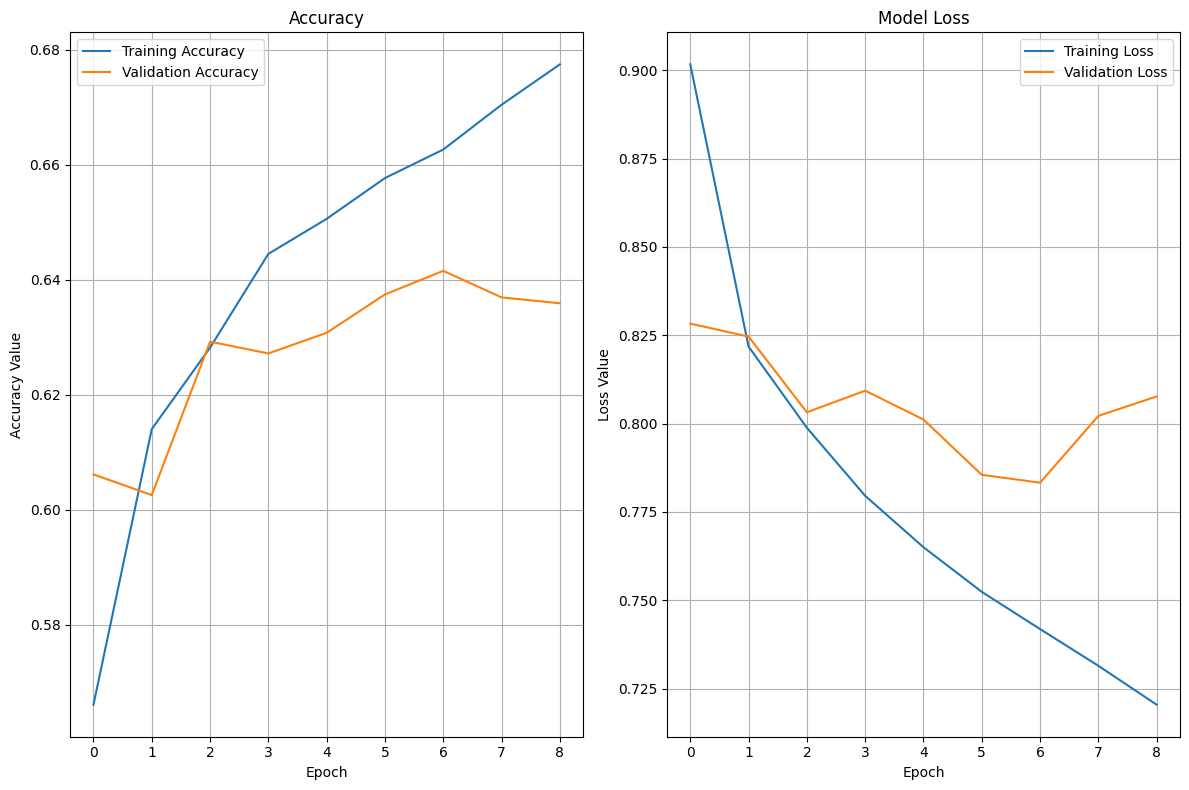

semeval-tweets/twitter-test1.txt (word-embedding-LSTM): 0.589
            positive  negative  neutral
positive    0.767     0.044     0.189     
negative    0.180     0.606     0.214     
neutral     0.269     0.130     0.602     

semeval-tweets/twitter-test2.txt (word-embedding-LSTM): 0.588
            positive  negative  neutral
positive    0.840     0.034     0.126     
negative    0.217     0.550     0.233     
neutral     0.406     0.073     0.520     

semeval-tweets/twitter-test3.txt (word-embedding-LSTM): 0.550
            positive  negative  neutral
positive    0.749     0.064     0.187     
negative    0.248     0.520     0.232     
neutral     0.298     0.120     0.582     



In [61]:
# Buid traditional sentiment classifiers. An example classifier name 'svm' is given
# in the code below. You should replace the other two classifier names
# with your own choices. For features used for classifier training, 
# the 'bow' feature is given in the code. But you could also explore the 
# use of other features.

for classifier in ['svm', 'naive-bayes', 'LSTM']:
    for features in ['bow', 'word-embedding']:
        # Skeleton: Creation and training of the classifiers
        if classifier == 'svm':
            # write the svm classifier here
            if features == 'word-embedding':
                continue
            print('Training ' + classifier)
            model = train_svm()
            
        elif classifier == 'naive-bayes':
            if features == 'word-embedding':
                continue
            # write the classifier 2 here
            print('Training ' + classifier)
            model = train_multinomialNB()
        elif classifier == 'LSTM':
            # write the LSTM classifier here
            if features == 'bow':
                continue
            print('Training ' + classifier)
            model = training_lstm()
        else:
            print('Unknown classifier name' + classifier)
            continue

        # Predition performance of the classifiers
        for testset in testsets:
            id_preds = {}
            # write the prediction and evaluation code here
            id_preds = prediction_dataset(model,testset,features + '-' + classifier)
            testset_name = testset
            testset_path = join('semeval-tweets', testset_name)
            evaluate(id_preds, testset_path, features + '-' + classifier)
            confusion(id_preds, testset_path, features + '-' + classifier)


In [62]:
setup_seed(42)
with open('lstm_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    for testset in testsets:
        id_preds = {}
        # write the prediction and evaluation code here
        id_preds = prediction_dataset(loaded_model,testset,'word-embedding-LSTM')
        testset_name = testset
        testset_path = join('semeval-tweets', testset_name)
        evaluate(id_preds, testset_path, 'word-embedding-LSTM')
        confusion(id_preds, testset_path, 'word-embedding-LSTM')

semeval-tweets/twitter-test1.txt (word-embedding-LSTM): 0.589
            positive  negative  neutral
positive    0.767     0.044     0.189     
negative    0.180     0.606     0.214     
neutral     0.269     0.130     0.602     

semeval-tweets/twitter-test2.txt (word-embedding-LSTM): 0.588
            positive  negative  neutral
positive    0.840     0.034     0.126     
negative    0.217     0.550     0.233     
neutral     0.406     0.073     0.520     

semeval-tweets/twitter-test3.txt (word-embedding-LSTM): 0.550
            positive  negative  neutral
positive    0.749     0.064     0.187     
negative    0.248     0.520     0.232     
neutral     0.298     0.120     0.582     

